## 1. Загрузка и обработка данных

### 1.1 Наличие пропусков и дубликатов

In [1]:
import pandas as pd
# Загрузка данных
ds_salaries = pd.read_csv('data/ds_salaries.csv')
# Создание копии
data = ds_salaries.copy()
# Отображение характеристик датасета
display(data.info())
# Начилие пропусков в каждом столбце
print('\nНачилие пропусков в каждом столбце\n', data.isnull().sum().to_frame())
# Наличие дубликатов в каждом столбце
print('\nНаличие дубликатов\n', data[data.duplicated()].shape[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


None


Начилие пропусков в каждом столбце
                     0
Unnamed: 0          0
work_year           0
experience_level    0
employment_type     0
job_title           0
salary              0
salary_currency     0
salary_in_usd       0
employee_residence  0
remote_ratio        0
company_location    0
company_size        0

Наличие дубликатов
 0


Датасет не имеет пропусков или дубликатов. Дополнительное исследование на значение, которым можно заменить пропуск, или возможность удаления пропусков по осями или дубликатов, проводить не нужно

### 1.2 Определение неинформативных признаков

Неинформативные признаки - признаки, имеющие сильную корреляцию\
Для выявления используется метод Кендалла, так как он устойчив к выбросам

,Unnamed: 0,work_year,salary,salary_in_usd,remote_ratio
Unnamed: 0,1.000000,0.764612,0.068628,0.166970,0.103185
work_year,0.764612,1.000000,0.077898,0.214867,0.115797
salary,0.068628,0.077898,1.000000,0.695795,0.088432
salary_in_usd,0.166970,0.214867,0.695795,1.000000,0.141753
remote_ratio,0.103185,0.115797,0.088432,0.141753,1.000000


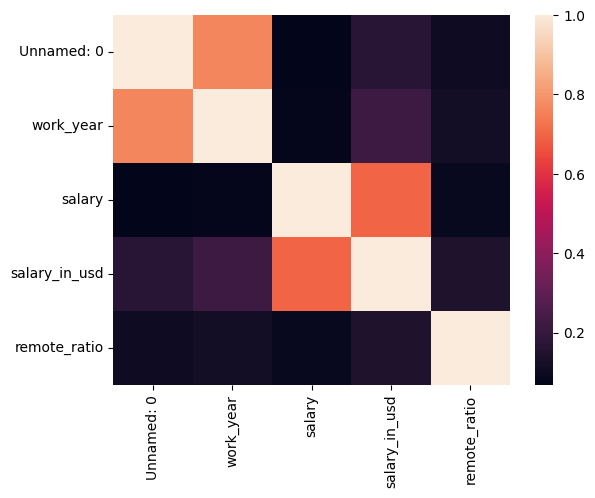

In [2]:
import seaborn as sns
# Построение корреляционной матрицы для выявления взавимозависимости
correlation = data.corr(method='kendall',numeric_only=True)
# Вывод коэффициентов корреляции
display(correlation)
# Тепловая карта корреляции
sns.heatmap(data.corr(method='kendall',numeric_only=True));

Исходя из тепловой карты, значения для признака Unnamed:0 обладают сильной корреляцией с коэффициентом > 0.7, поэтому этот признак следует удалить

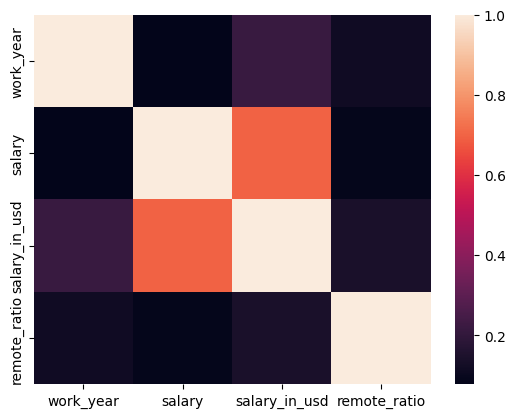

In [3]:
data = data.drop(['Unnamed: 0'], axis=1)
# Тепловая карта корреляции после удаления
sns.heatmap(data.corr(method='kendall',numeric_only=True));

Остальные признаки имеют корреляционные коффициенты < 0.7

### 1.3 Классификация признаков на числовые и категориальные

Числовые признаки имеют много уникальных значений, категориальные обычно < 4. Но основываясь на описании столбцов, данных в модуле, возьмем 5 уникальных значений

In [4]:
# Список для записи категориальных признаков
list_categorial = list()
# Цикл для вывода столбцов категориальных признаков
for column in data.columns:
    if data[column].nunique() < 5:
        list_categorial.append(column)
        print(column, ' ', data[column].nunique())

work_year   3
experience_level   4
employment_type   4
remote_ratio   3
company_size   3


Следовательно все остальные признаки - числовые

Можно преобразовать признаки из текста в числа и вывести уже с учетом этого матрицу корреляций\
Но для начала нужно знать сколько у номинальных призанков уникальных значений -> исходя из этого выбрать тип кодирования

In [5]:
import category_encoders as ce
# Так как уникальных значений немного, выбрано однократное кодирование
encoder = ce.OneHotEncoder(cols=list_categorial, use_cat_names=True)
cols_bin = encoder.fit_transform(data[list_categorial])
data = pd.concat([data, cols_bin], axis=1)
data[list_categorial].head(4)

,work_year,experience_level,employment_type,remote_ratio,company_size
0,2020,MI,FT,0,L
1,2020,SE,FT,0,S
2,2020,SE,FT,50,M
3,2020,MI,FT,0,S


In [6]:
# Цикл для вывода столбцов номинальных признаков
for column in data.columns:
    if data[column].nunique() > 15:
        list_categorial.append(column)
        print(column, ' ', data[column].nunique())

job_title   50
salary   272
salary_currency   17
salary_in_usd   369
employee_residence   57
company_location   50


Итерес представляют employee_residence и company_location. Так как уникальных значений больше 15 - бинарное кодирование

In [7]:
encoder = ce.BinaryEncoder(cols=['employee_residence', 'company_location'])
cols_bin = encoder.fit_transform(data[['employee_residence', 'company_location']])
data = pd.concat([data, cols_bin], axis=1)
data.head(4)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,...,employee_residence_2,employee_residence_3,employee_residence_4,employee_residence_5,company_location_0,company_location_1,company_location_2,company_location_3,company_location_4,company_location_5
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,...,0,0,0,1,0,0,0,0,0,1
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,...,0,0,1,0,0,0,0,0,1,0
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,...,0,0,1,1,0,0,0,0,1,1
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,...,0,1,0,0,0,0,0,1,0,0


Отображение тепловой карты с учетом преобразования категориальных признаков


<Axes: >

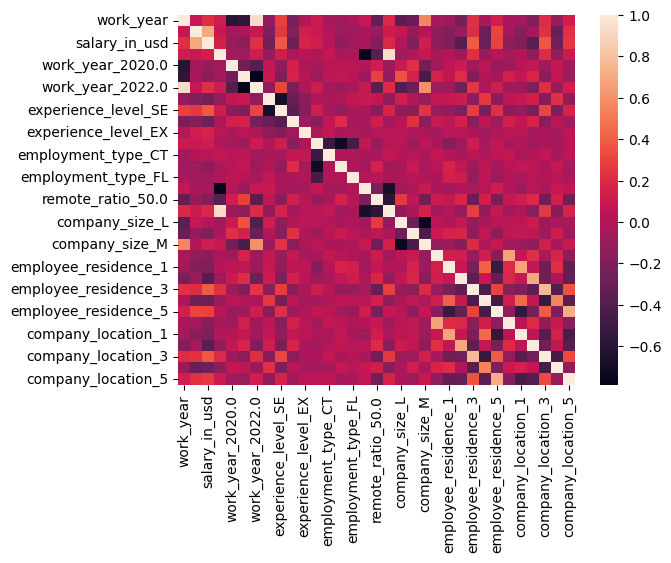

In [8]:
correlation_cat = data.corr(method='kendall',numeric_only=True)
print('Отображение тепловой карты с учетом преобразования категориальных признаков')
display(sns.heatmap(correlation_cat))

Видно, что есть сильная корреляция между категориальными признаками. Их нужно почистить

In [9]:
# За коэффициент сильной корреляции примем 0.7. Сравним признаки
mask = (correlation_cat > 0.7) & (correlation_cat != 1) | (correlation_cat < -0.7)
# Удалим дубликаты и приведем данные в вертикальном формате
print('Наибольшей положительной или отрицательной корреляцией обладают следующие признаки:')
display(correlation_cat[mask].stack().dropna().drop_duplicates())

Наибольшей положительной или отрицательной корреляцией обладают следующие признаки:


work_year             work_year_2022.0      0.924497
remote_ratio          remote_ratio_0.0     -0.785977
                      remote_ratio_100.0    0.934124
work_year_2021.0      work_year_2022.0     -0.782460
employment_type_FT    employment_type_PT   -0.719987
company_size_L        company_size_M       -0.749422
employee_residence_3  company_location_3    0.765408
employee_residence_5  company_location_5    0.708075
dtype: float64

Отображение тепловой карты с учетом преобразования категориальных признаков после удаления сильной корреляции


<Axes: >

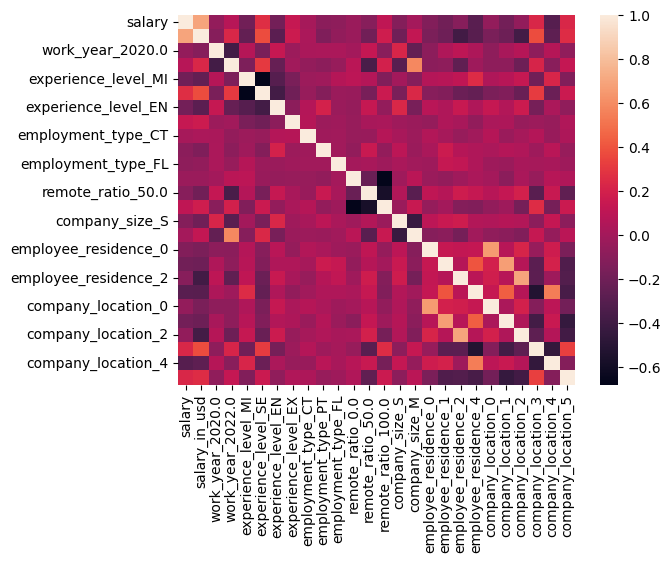

In [10]:
high_corr_columns = ['work_year', 'remote_ratio', 'work_year_2021.0', 'employment_type_FT', 'company_size_L',
                      'employee_residence_3', 'employee_residence_5']
data = data.drop(high_corr_columns, axis=1)
correlation_cat = data.corr(method='kendall',numeric_only=True)
print('Отображение тепловой карты с учетом преобразования категориальных признаков после удаления сильной корреляции')
display(sns.heatmap(correlation_cat))

В данных еще остался тип object. Что из себя представляют эти данные:

In [11]:
# Вывод наименований столбцов списком с типом object
data.select_dtypes(include=['object']).columns.to_list()

['experience_level',
 'employment_type',
 'job_title',
 'salary_currency',
 'employee_residence',
 'company_location',
 'company_size']

job_title - признак, по которому будем фильтровать вакансии для Data Scients'ов от остальных\
employee_residence - основная страна проживания сотрудника в течение рабочего года в виде кода страны\
company_location - страна главного офиса работодателя

последние два признака нужно использовать для анализа зависимости зарплаты

### 1.4 Основные статистические характеристики каждого из признаков

In [12]:
print('Основные статистические харакетриктики столбцов')
display(data.describe())
print('Вывод стандартных отклонений')
display(data.describe().loc['std'])

Основные статистические харакетриктики столбцов


,salary,salary_in_usd,work_year_2020.0,work_year_2022.0,experience_level_MI,experience_level_SE,experience_level_EN,experience_level_EX,employment_type_CT,employment_type_PT,...,employee_residence_0,employee_residence_1,employee_residence_2,employee_residence_4,company_location_0,company_location_1,company_location_2,company_location_3,company_location_4,company_location_5
count,6.070000e+02,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,...,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.00000,607.000000,607.000000,607.000000
mean,3.240001e+05,112297.869852,0.118616,0.523888,0.350906,0.461285,0.144975,0.042834,0.008237,0.016474,...,0.054366,0.153213,0.191104,0.248764,0.044481,0.133443,0.15486,0.670511,0.164745,0.836903
std,1.544357e+06,70957.259411,0.323603,0.499841,0.477647,0.498910,0.352366,0.202649,0.090459,0.127396,...,0.226925,0.360489,0.393495,0.432654,0.206331,0.340334,0.36207,0.470415,0.371256,0.369759
min,4.000000e+03,2859.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,7.000000e+04,62726.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000
50%,1.150000e+05,101570.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000
75%,1.650000e+05,150000.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000
max,3.040000e+07,600000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


Вывод стандартных отклонений


salary                  1.544357e+06
salary_in_usd           7.095726e+04
work_year_2020.0        3.236030e-01
work_year_2022.0        4.998409e-01
experience_level_MI     4.776472e-01
experience_level_SE     4.989100e-01
experience_level_EN     3.523663e-01
experience_level_EX     2.026488e-01
employment_type_CT      9.045917e-02
employment_type_PT      1.273962e-01
employment_type_FL      8.097631e-02
remote_ratio_0.0        4.070913e-01
remote_ratio_50.0       3.697590e-01
remote_ratio_100.0      4.838225e-01
company_size_S          3.438540e-01
company_size_M          4.990353e-01
employee_residence_0    2.269250e-01
employee_residence_1    3.604893e-01
employee_residence_2    3.934949e-01
employee_residence_4    4.326535e-01
company_location_0      2.063314e-01
company_location_1      3.403335e-01
company_location_2      3.620695e-01
company_location_3      4.704154e-01
company_location_4      3.712559e-01
company_location_5      3.697590e-01
Name: std, dtype: float64

Если стандратное отклонение большое - нужно нормализовать признак\
Такое поведение для salary, salary_in_usd

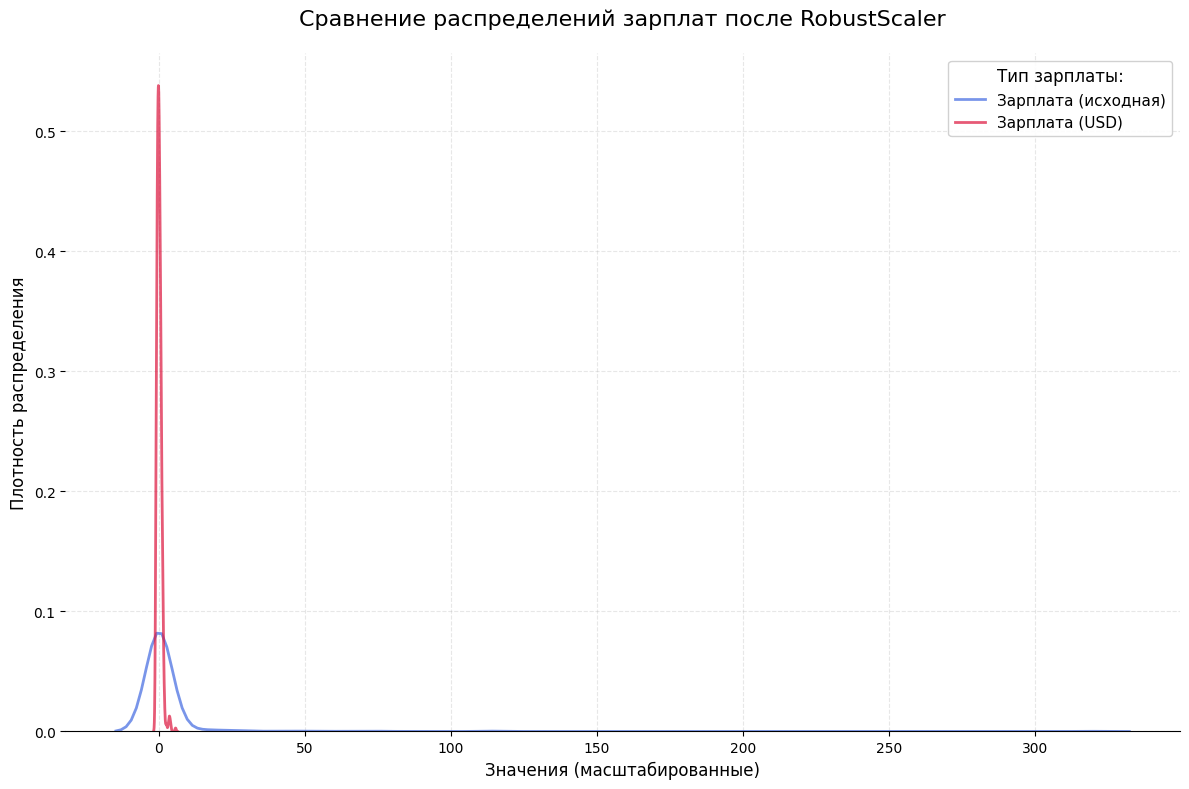

In [13]:
import matplotlib
import matplotlib.pyplot as plt
# для нормализации, стандартизации
from sklearn import preprocessing
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()
# кодируем исходный датасет
df_r = r_scaler.fit_transform(data[['salary', 'salary_in_usd']])
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=['salary', 'salary_in_usd'])
plt.figure(figsize=(12, 8))
# График распределений
ax = sns.kdeplot(df_r['salary'], 
                 color='royalblue',
                 label='Зарплата (исходная)',
                 linewidth=2,
                 alpha=0.7)
ax = sns.kdeplot(df_r['salary_in_usd'], 
                 color='crimson',
                 label='Зарплата (USD)',
                 linewidth=2,
                 alpha=0.7)
plt.title('Сравнение распределений зарплат после RobustScaler', 
          fontsize=16, 
          pad=20)
plt.xlabel('Значения (масштабированные)', fontsize=12)
plt.ylabel('Плотность распределения', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Тип зарплаты:', 
           title_fontsize=12,
           fontsize=11,
           frameon=True,
           framealpha=0.9)
sns.despine(left=True)
plt.tight_layout()
plt.show()

In [14]:
data = data.drop(['salary', 'salary_in_usd'], axis=1).join(df_r)
print('Основные статистические харакетриктики столбцов после нормализации')
display(data.describe())
print('Вывод стандартных отклонений после нормализации')
display(data.describe().loc['std'])

Основные статистические харакетриктики столбцов после нормализации


,work_year_2020.0,work_year_2022.0,experience_level_MI,experience_level_SE,experience_level_EN,experience_level_EX,employment_type_CT,employment_type_PT,employment_type_FL,remote_ratio_0.0,...,employee_residence_2,employee_residence_4,company_location_0,company_location_1,company_location_2,company_location_3,company_location_4,company_location_5,salary,salary_in_usd
count,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,607.000000,...,607.000000,607.000000,607.000000,607.000000,607.00000,607.000000,607.000000,607.000000,607.000000,607.000000
mean,0.118616,0.523888,0.350906,0.461285,0.144975,0.042834,0.008237,0.016474,0.006590,0.209226,...,0.191104,0.248764,0.044481,0.133443,0.15486,0.670511,0.164745,0.836903,2.200001,0.122922
std,0.323603,0.499841,0.477647,0.498910,0.352366,0.202649,0.090459,0.127396,0.080976,0.407091,...,0.393495,0.432654,0.206331,0.340334,0.36207,0.470415,0.371256,0.369759,16.256395,0.813040
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.168421,-1.131047
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,-0.473684,-0.445081
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,1.000000,0.526316,0.554919
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,318.789474,5.711094


Вывод стандартных отклонений после нормализации


work_year_2020.0         0.323603
work_year_2022.0         0.499841
experience_level_MI      0.477647
experience_level_SE      0.498910
experience_level_EN      0.352366
experience_level_EX      0.202649
employment_type_CT       0.090459
employment_type_PT       0.127396
employment_type_FL       0.080976
remote_ratio_0.0         0.407091
remote_ratio_50.0        0.369759
remote_ratio_100.0       0.483822
company_size_S           0.343854
company_size_M           0.499035
employee_residence_0     0.226925
employee_residence_1     0.360489
employee_residence_2     0.393495
employee_residence_4     0.432654
company_location_0       0.206331
company_location_1       0.340334
company_location_2       0.362070
company_location_3       0.470415
company_location_4       0.371256
company_location_5       0.369759
salary                  16.256395
salary_in_usd            0.813040
Name: std, dtype: float64

### Вывод по пункту 1

Стандартное отклонение salary_in_usd небольшое, далее будем использовать этот признак для анализа

## 2. Разведывательный анализ данных

### 2.1 Визуальный анализ данных

Нужен для ответа на вопрос:\
Какие факторы влияют на зарплату Data_Scientist'a?

In [15]:
# Критерий фильтрации, который будет использоваться ниже:
# Регулярное выражение помогает найти в тексте нужное сочетание. Поиск осуществляем в наименовании позиции job_title
import re
pattern = r'\b(Data\s*Scientist|Machine\s*Learning|AI|ML)\b'
matches = data['job_title'].str.extractall(pattern, flags=re.IGNORECASE)[0]
print('Значения, найденые регулярным выражением')
matches.value_counts()

Значения, найденые регулярным выражением


0
Data Scientist      159
Machine Learning     62
AI                    7
ML                    6
Name: count, dtype: int64

In [16]:
# Создаем булевую переменную обозначающую, что нужное сочетание найдено
data['is_keyword'] = data['job_title'].str.contains(pattern, flags=re.IGNORECASE, na=False)

C:\Users\Uluana\AppData\Local\Temp\ipykernel_3620\4059093280.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  data['is_keyword'] = data['job_title'].str.contains(pattern, flags=re.IGNORECASE, na=False)


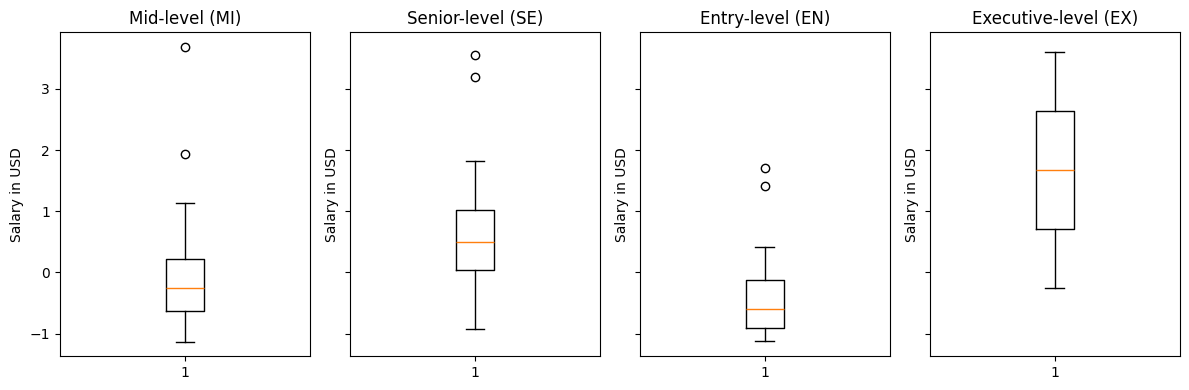

In [17]:
# Построение графиков влияния опыта работы на зарплату в usd
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12, 4), sharey=True)

# Mid-level (MI)
mi_data = data[(data['experience_level_MI'] == 1) & data['is_keyword']]['salary_in_usd']
axs[0].boxplot(mi_data)
axs[0].set_title('Mid-level (MI)')
# Senior-level (SE)
se_data = data[(data['experience_level_SE'] == 1) & data['is_keyword']]['salary_in_usd']
axs[1].boxplot(se_data)
axs[1].set_title('Senior-level (SE)')
# Entry-level (EN)
en_data = data[(data['experience_level_EN'] == 1) & data['is_keyword']]['salary_in_usd']
axs[2].boxplot(en_data)
axs[2].set_title('Entry-level (EN)')
# Executive-level (EX)
ex_data = data[(data['experience_level_EX'] == 1) & data['is_keyword']]['salary_in_usd']
axs[3].boxplot(ex_data)
axs[3].set_title('Executive-level (EX)')

for ax in axs.flat:
    ax.set(ylabel='Salary in USD')

fig.tight_layout()
plt.show()

Зарплаты распределяются по возрастанию: Entry-level (EN) < Mid-level (MI) < Senior-level (SE) < Executive-level (EX). Executive-level (EX) имеет наиболее высокие зарплаты, что соответствует высокой ответственности и опыту. 

Уровни с большим опытом (SE, EX) могут демонстрировать больший разброс зарплат из-за специализации, бонусов, или дополнительных условий. Entry-level (EN) и Mid-level (MI) обычно имеют более узкий разброс, так как зарплаты на этих позициях чаще стандартизированы. 

Наличие выбросов (особенно на уровнях SE и MI) может указывать на значительную вариативность в оплате труда (например, в зависимости от компании, локации, или навыков). Для EN и EX выбросы менее выражены, что говорит о более жестких рамках зарплатных вилок. 

Так как данные нормализованы по RobustScaler, метрики устойчивы к выбросам. Это значит, что медианные значения и межквартильные диапазоны (IQR) точно отражают распределение. Медианы (линии внутри боксов) показывают "типичную" зарплату для каждого уровня. Разница между медианами уровней должна быть статистически значимой.

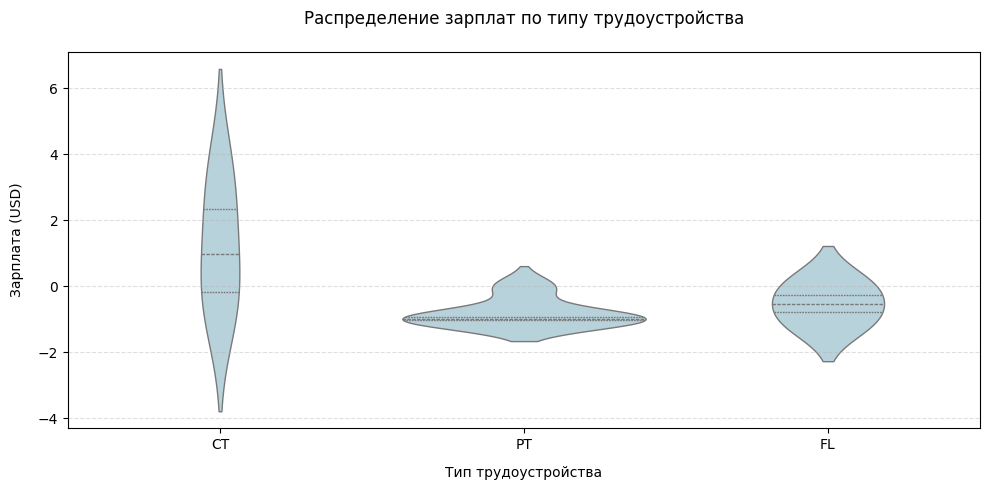

In [18]:
# Построение графиков влияния типа трудоустройства на зарплату в usd
plt.figure(figsize=(10, 5))
sns.violinplot(
    x='employment_type', 
    y='salary_in_usd', 
    data=data[data['is_keyword']],
    order=['CT', 'PT', 'FL'],
    inner='quartile',
    linewidth=1,
    saturation=0.6,
    color='lightblue',
    alpha=1
)

plt.title('Распределение зарплат по типу трудоустройства', pad=20)
plt.xlabel('Тип трудоустройства', labelpad=10)
plt.ylabel('Зарплата (USD)', labelpad=10)
plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

Сравнение толщины: наибольшая у PT (неполный рабочий день) -> больше всего данных этого типа трудоустройства\
Сравнение медиан: самая высокая у CT (CT > FL > PT) -> тип занятости "по контракту" в среднем имеет выше зарплату\
Сравнение длины: наибольшая у CT (особенно в верхнем квантиле 75%) ->
 - много высокооплачиваемых позиций
 - 25% ближе к медиане, чем 75% -> больше высоких зарплат

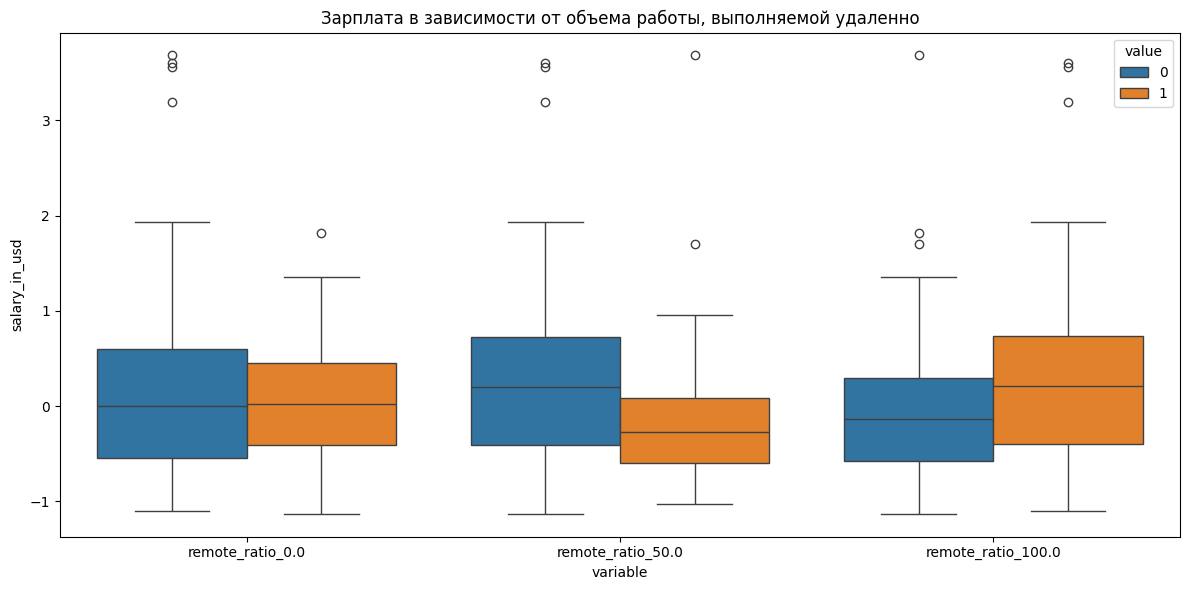

In [19]:
# Функция для фильтрации существующих столбцов
def get_existing_columns(prefix):
    return [col for col in data.columns if col.startswith(prefix)]

# График для remote_ratio (только существующие столбцы)
plt.figure(figsize=(12, 6))
remote_cols = get_existing_columns('remote_ratio_')
if remote_cols:
    sns.boxplot(data=data[data['is_keyword']].melt(id_vars='salary_in_usd', 
                            value_vars=remote_cols),
              x='variable', y='salary_in_usd', hue='value')
    plt.title('Зарплата в зависимости от объема работы, выполняемой удаленно')

plt.tight_layout()
plt.show()

В полность офисном режиме разброс зарплат узкий, медиана ниже, чем в остальных\
При выполнении работы на 50% удаленно разброс зарплат больше, чем в офисе, при это медиана ниже\
При выполнении работы 100% дистанционно медиана выше остальных режимов, разброс зарплат больше офиса, но немного меньше наполовину удаленного режима

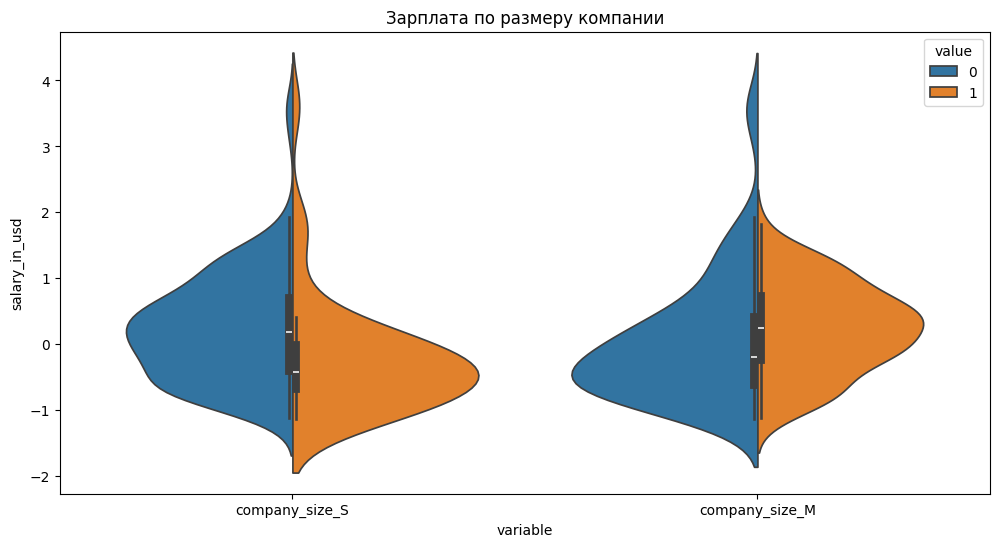

In [20]:
# График для company_size (только существующие столбцы)
plt.figure(figsize=(12, 6))
company_cols = get_existing_columns('company_size_')
if company_cols:
    sns.violinplot(data=data[data['is_keyword']].melt(id_vars='salary_in_usd',
                                value_vars=company_cols),
                 x='variable', y='salary_in_usd', hue='value', split=True)
    plt.title('Зарплата по размеру компании')

Компании Middle платят в среднем больше, чем компании Small

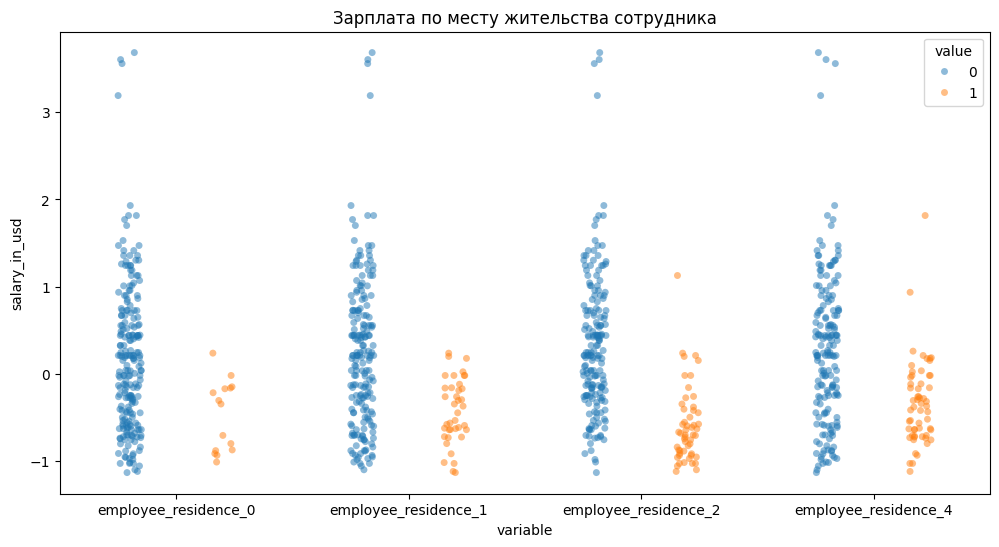

In [21]:
# График для employee_residence (только существующие столбцы)
plt.figure(figsize=(12, 6))
residence_cols = get_existing_columns('employee_residence_')
if residence_cols:
    # Используем strip plot для бинарных переменных
    sns.stripplot(data=data[data['is_keyword']].melt(id_vars='salary_in_usd',
                                value_vars=residence_cols),
                 x='variable', y='salary_in_usd', hue='value',
                 dodge=True, jitter=True, alpha=0.5)
    plt.title('Зарплата по месту жительства сотрудника')

В стране проживания сотрудника employee_residence_4 зарплаты наиболее конкруентные по сравнению с остальными странами\
По убыванию номера employee_residence_x конкурентноспособность падает

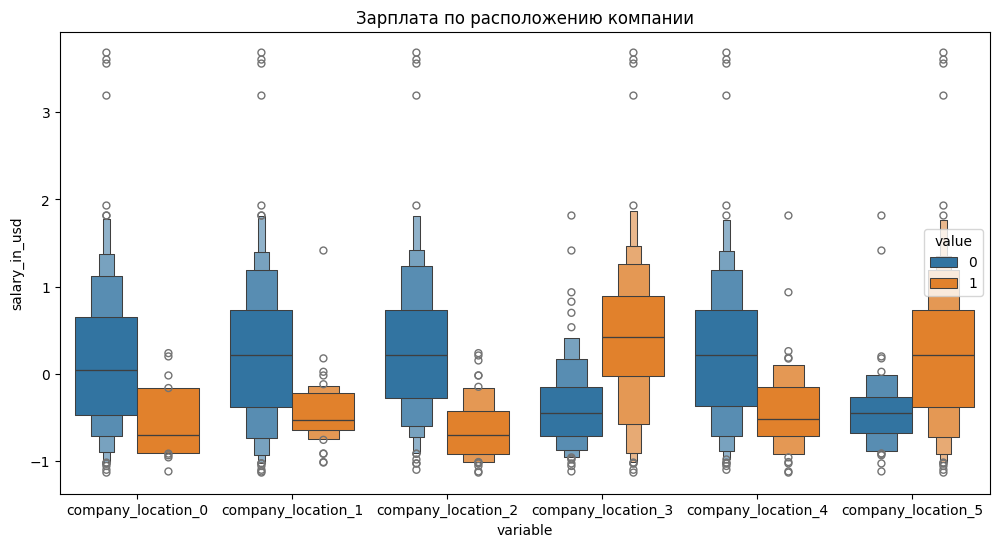

In [22]:
# График для company_location (только существующие столбцы)
plt.figure(figsize=(12, 6))
location_cols = get_existing_columns('company_location_')
if location_cols:
    sns.boxenplot(data=data[data['is_keyword']].melt(id_vars='salary_in_usd',
                               value_vars=location_cols),
                x='variable', y='salary_in_usd', hue='value')
    plt.title('Зарплата по расположению компании')

Выплачиваемые зарплаты в локацииях компний 3,5 в среднем выше, по сравнению с остальными городами\
Наименьший разброс у локаций 0-2

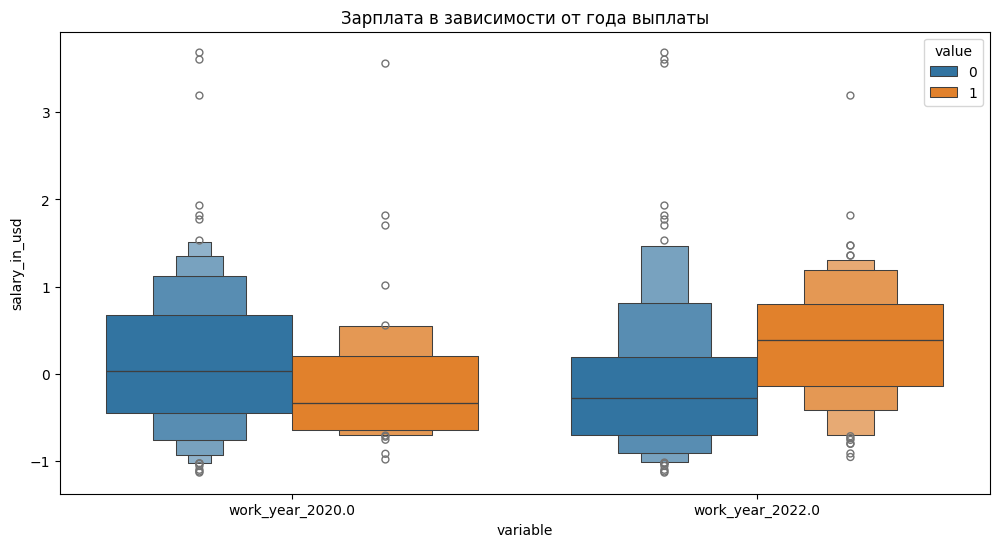

In [23]:
# График для выплаченной ЗП (только существующие столбцы)
plt.figure(figsize=(12, 6))
location_cols = get_existing_columns('work_year_')
if location_cols:
    sns.boxenplot(data=data[data['is_keyword']].melt(id_vars='salary_in_usd',
                               value_vars=location_cols),
                x='variable', y='salary_in_usd', hue='value')
    plt.title('Зарплата в зависимости от года выплаты')

Наблюдается тенденция роста в выплачиваемых зарплатах с увелчением года выплат\
Медиана для 2022 года смещена к 75% квантилю, что говорит о высокой выплачиваемой зарплате в среднем, если распределение нормальное

### Вывод по подпункту 2.1

1. Зарплаты возрастают от EN к EX с увеличением опыта
2. В среднем по контракту для позици Data Scien'тистов зарплата выплачивается выше
3. Сотрудники на полной удаленной работе в средем получают зарплату выше
4. Middle компании в среднем платят больше, чем small
5. В стране employee_residence_4 зарплаты наиболее конкурентные, а с уменьшением номера (employee_residence_x) конкурентоспособность падает
6. Наблюдается тенденция роста зарплат с увеличением года выплат

**Гипотезы к проверке:**

1. Уровень позиции\
H0: Медианные зарплаты не различаются между уровнями позиции (EN = MI = SE = EX).\
H1: Медианные зарплаты возрастают с увеличением уровня позиции (EN < MI < SE < EX).

2. Тип занятости\
H0: Медианные зарплаты не различаются между типами занятости (PT = FL = CT).\
H1: Медианные зарплаты различаются, причём CT > FL > PT.

3. Режим работы\
H0: Медианные зарплаты не различаются между режимами работы (0% = 50% = 100% удалёнки).\
H1: Медианные зарплаты выше при полностью удалённой работе (100% > 50% > 0%).

4. Размер компании\
H0: Медианные зарплаты не различаются между компаниями разного размера (Small = Middle).\
H1: Средние компании платят больше, чем малые (Middle > Small).

5. Локация сотрудника\
H0: Медианные зарплаты не различаются между странами проживания сотрудников.\
H1: Зарплаты в стране employee_residence_4 выше, чем в остальных (4 > 3 > 2 > 1 > 0).

6. Локация компании\
H0: Медианные зарплаты не различаются между локациями компаний.\
H1: Локации 3 и 5 платят больше, чем 0-2 (3 ≈ 5 > 0 ≈ 1 ≈ 2).

7. Год выплат\
H0: Медианные зарплаты не различаются между годами.\
H1: Зарплаты растут с увеличением года (2022 > 2021 > 2020).

### 2.2 Статистический анализ данных 

In [24]:
import scipy.stats as stats
# Уровень значимости везде одинаков
alpha = 0.05

-----

H0: Медианные зарплаты не различаются между уровнями позиции (EN = MI = SE = EX).\
H1: Медианные зарплаты возрастают с увеличением уровня позиции (EN < MI < SE < EX).

-----

Чтобы выбрать метод, надо понять, распределен ли признак нормально

In [25]:
# Для каждого уровня опыта проводим тест отдельно:
levels = ['experience_level_EN', 'experience_level_EX', 'experience_level_MI', 'experience_level_SE']

for level in levels:
    # Выбираем зарплаты для текущего уровня (предполагаем, что salary_in_usd - столбец с зарплатами)
    level_data = data[data[level] == 1]['salary_in_usd'].dropna()
    
    # Проверяем размер выборки (тест Шапиро работает для 3 < n < 5000)
    if len(level_data) < 3:
        print(f'{level}: Недостаточно данных для теста (n < 3)')
        continue
    
    # Проводим тест Шапиро-Уилка
    stat, p_value = stats.shapiro(level_data)
    print(f'{level}: p-value = {p_value:.3f}')
    
    # Интерпретация
    if p_value <= alpha:
        print(f'Распределение зарплат для {level} не нормальное (p ≤ {alpha})')
    else:
        print(f'Распределение зарплат для {level} нормальное (p > {alpha})')

experience_level_EN: p-value = 0.000
Распределение зарплат для experience_level_EN не нормальное (p ≤ 0.05)
experience_level_EX: p-value = 0.001
Распределение зарплат для experience_level_EX не нормальное (p ≤ 0.05)
experience_level_MI: p-value = 0.000
Распределение зарплат для experience_level_MI не нормальное (p ≤ 0.05)
experience_level_SE: p-value = 0.000
Распределение зарплат для experience_level_SE не нормальное (p ≤ 0.05)


Распределение ненормальное -> непараметрический тест Краскелла-Уоллиса

In [26]:
# Проводим тест сданными опыта работы
_, p = stats.kruskal(data['experience_level_EN'], data['experience_level_EX'], data['experience_level_MI'], data['experience_level_SE'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


Нулевая гипотеза неверна -> влияния опыта работы имеет статистическую значимость

----

H0: Медианные зарплаты не различаются между типами занятости (PT = FL = CT).\
H1: Медианные зарплаты различаются, причём CT > FL > PT.

-----

### Вывод по подпункту 2.2

### Вывод по пунтку 2

## 3. Ответы на вопросы

Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

## 4. Дополнительное исследование

### 4.1 Визуальный анализ

### Выводы по подпункту 4.1

### 4.2 Статистический анализ

### Выводы по подпункту 4.2

### Вывод по пунтку 4